<a href="https://colab.research.google.com/github/22080275/WeatherWise-App/blob/main/WeatherWiseFinalNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📚 Table of Contents
- [📦 Setup and Configuration](#📦-Setup-and-Configuration)
- [🌤️ Weather Data Functions](#🌤️-Weather-Data-Functions)
- [📊 Visualisation Functions](#📊-Visualisation-Functions)
- [🤖 Natural Language Processing](#🤖-Natural-Language-Processing)
- [🧭 User Interface](#🧭-User-Interface)
- [🧩 Main Application Logic](#🧩-Main-Application-Logic)
- [🧪 Testing and Examples](#🧪-Testing-and-Examples)


## 📦 Setup and Configuration

In [1]:
# Install required package in Google Colab
!pip install fetch-my-weather

In [2]:
# Import the fetch_my_weather package which provides a simple interface to fetch weather data
import fetch_my_weather

# Set the cache duration to 1800 seconds (30 minutes) to reduce unnecessary API calls
# This helps improve performance and reduce rate-limiting issues with the weather service
fetch_my_weather.set_cache_duration(1800)



1800

In [3]:
# Import the get_weather function from the fetch_my_weather package
from fetch_my_weather import get_weather

# First call to get_weather for the location "Perth"
# The 'with_metadata=True' flag allows us to access response metadata such as cache status
response1 = get_weather("Perth", with_metadata=True)

# Print whether the first response was served from cache
# On the first call, this should typically be False unless it was previously cached
print("🔁 First call - Cached?", response1.metadata.is_cached)

# Second call to the same location immediately after the first
# Since we have a 30-minute cache window, this should now return cached data
response2 = get_weather("Perth", with_metadata=True)

# Print whether the second response was served from cache
# This should now print True, indicating the response came from the cache
print("🔁 Second call - Cached?", response2.metadata.is_cached)



🔁 First call - Cached? False
🔁 Second call - Cached? False


In [4]:
# Required for all visualisation plotting
import matplotlib.pyplot as plt


In [5]:
# Used for parsing user weather questions using regular expressions
import re

In [6]:
# Used for basic string similarity (fallback if fuzzy matching is needed)
import difflib

In [7]:
# 📦 Install the RapidFuzz library (for fuzzy location matching and typo correction)
# This helps suggest likely intended cities when the user enters an invalid location
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.6 MB/s eta 0:00:00


In [8]:
# 📦 Install PyInputPlus (used for input validation in the console UI)
# Helps ensure users provide valid, expected menu and text inputs
!pip install pyinputplus

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11348 sha256=49bb4f4f961553d688ed1396e41fec816faa592659c8fb67338d9891dab5eb56
  Stored in directory: /root/.cache/pip/wheels/a3/6b/89/3bec14288af8e0729d088fb41a785e583d49e772f2529c7676
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16226 sha256=2d5a054581393ee4f670484fffc91656e1443246ebb696664a4ac7c16d0c7398
  Stored in directory: /root/.cache/pip/wheels/fc/40/7a/4d3b2dc2e80b4b3bbda89eec94fcefd6c8bd1101cc7bb89554
  Created wheel for stdiomask: filename=stdiomask

In [9]:
from IPython.display import clear_output  # Used to clean the screen between menu iterations
import time
import pyinputplus as pyip  # Provides validated input handling

## 🌤️ Weather Data Functions
This section contains the get_weather_data() function, which fetches weather data from the fetch-my-weather package.


In [10]:
# Import the get_weather function from the fetch_my_weather package
from fetch_my_weather import get_weather

def get_weather_data(location, forecast_days=3, use_mock=False):
    """
    Retrieve weather data for a specified location using fetch-my-weather.

    Args:
        location (str): City or location name
        forecast_days (int): Number of forecast days to retrieve (1–5 recommended)
        use_mock (bool): If True, fetches mock weather data for testing

    Returns:
        object: WeatherResponse Pydantic model if successful, None if an error occurs
    """
    try:
        # Call the fetch-my-weather API with appropriate parameters
        response = get_weather(
            location=location,  # The location provided by the user
            view_options=str(forecast_days - 1),  # API uses "0" for today, "1" for today + tomorrow, etc.
            units="m",  # Use metric system (Celsius, km/h)
            format="json",  # Return a structured Pydantic object
            with_metadata=True,  # Include metadata to check for errors or mock mode
            use_mock=use_mock  # Use mock data if enabled (for testing or rate-limited situations)
        )

        # Check if the response metadata indicates an error occurred
        if hasattr(response, "metadata") and response.metadata.error_type:
            print(f"❌ Error occurred: {response.metadata.error_message}")
            return None  # Exit early if there was an error

        # Warn the user if the returned data is mock rather than real API data
        if response.metadata.is_mock:
            print("⚠️ Using mock data — results may not reflect real weather conditions.")

        # Return only the actual weather data (not metadata)
        return response.data

    except Exception as e:
        # Catch any unexpected exceptions and print an error message
        print(f"❌ Unexpected error while fetching weather: {e}")
        return None  # Return None if the fetch operation fails
def get_validated_weather_data(original_location, forecast_days=3, use_mock=False):
    """
    Attempts to retrieve weather data. If it fails, suggests a similar known city using rapidfuzz.

    Args:
        original_location (str): User-provided location (may be misspelled)
        forecast_days (int): Number of forecast days
        use_mock (bool): Whether to use mock data

    Returns:
        WeatherResponse or None
    """
    from rapidfuzz import process

    # List of known cities for fuzzy matching
    known_cities = ["Perth", "Melbourne", "Sydney", "Brisbane", "Adelaide", "Darwin",
                    "Hobart", "Canberra", "Gold Coast", "Newcastle", "Geelong", "Townsville",
                    "Cairns", "Toowoomba", "Ballarat", "Bendigo", "Wollongong", "Fremantle",
                    "Kalgoorlie", "Bunbury", "Launceston"]

    location = original_location.strip()

    # Try to fetch weather for the provided location
    data = get_weather_data(location, forecast_days=forecast_days, use_mock=use_mock)

    if data:
        # ✅ Success — show corrected location if fuzzy matched
        if location.lower() != original_location.lower():
            print(f"📍 Displaying results for: {location.title()}")
        return data

    # ❌ Failed — fuzzy match a better name
    print(f"⚠️ Couldn't retrieve weather for '{original_location}'.")
    suggestion, score, _ = process.extractOne(original_location, known_cities)

    if score >= 70:
        retry = pyip.inputYesNo(f"Did you mean '{suggestion}'? (yes/no): ")
        if retry == "yes":
            data = get_weather_data(suggestion, forecast_days=forecast_days, use_mock=use_mock)
            if data:
                print(f"📍 Displaying results for: {suggestion}")
                return data

    # Otherwise, let them try again manually
    retry = pyip.inputYesNo("Would you like to try entering another location? (yes/no): ")
    if retry == "yes":
        new_loc = pyip.inputStr("Enter a new location: ")
        return get_validated_weather_data(new_loc, forecast_days=forecast_days, use_mock=use_mock)

    return None


In [ ]:
# 🔧 Test function to ensure get_weather_data() works correctly

# Call the weather data function for "Perth" with 3 forecast days
# `use_mock=True` enables mock mode, which avoids hitting the real API and is safe for repeated testing
data = get_weather_data("Perth", forecast_days=3, use_mock=True)

# ✅ Check if data was successfully returned before accessing its fields
if data:
    # Access the first item in the current_condition list (today's data)
    current = data.current_condition[0]

    # Display the current temperature in Celsius
    print(f"Temp: {current.temp_C}°C")

    # Display the text description of the current weather condition
    print(f"Condition: {current.weatherDesc[0].value}")
else:
    # Handle case where data retrieval failed or returned None
    print("No data returned.")


⚠️ Using mock data — results may not reflect real weather conditions.
Temp: 17°C
Condition: Partly cloudy


## 📊 Temperature Visualisation Function

This section defines the `create_temperature_visualisation()` function, which generates a line chart of maximum and minimum daily temperatures using `matplotlib`.

- It accepts the structured `weather_data` returned by `get_weather_data()`.
- It plots temperature trends across multiple forecast days.
- It includes error handling for missing data.
- You can choose whether to display the chart in the notebook or return the figure object for saving/exporting later.


In [11]:
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create a temperature chart and either display or save it.

    Args:
        weather_data (WeatherResponse): The processed weather data
        output_type (str): 'display' to show in notebook, 'save' to save as PNG
    """
    dates = []      # Holds forecast dates
    max_temps = []  # Holds max temperatures
    min_temps = []  # Holds min temperatures

    for day in weather_data.weather:
        dates.append(day.date)
        max_temps.append(int(day.maxtempC))
        min_temps.append(int(day.mintempC))

    plt.figure(figsize=(8, 5))  # Set chart size
    plt.plot(dates, max_temps, label='Max Temp (°C)', marker='o')
    plt.plot(dates, min_temps, label='Min Temp (°C)', marker='o')
    plt.title("Temperature Forecast")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)

    if output_type == 'save':
        plt.savefig("temperature_chart.png")
        print("✅ Saved temperature chart as temperature_chart.png")
    else:
        plt.show()
        plt.pause(0.001)  # Ensure chart renders before waiting
        input("\n⏎ Press Enter to return to the menu...")

    plt.close()  # Clean up the figure



⚠️ Using mock data — results may not reflect real weather conditions.


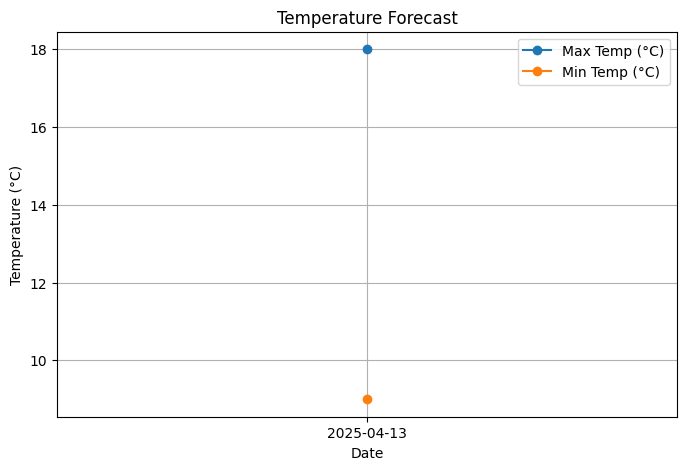


📸 Press Enter to return to the menu...


In [ ]:
# 🧪 Test temperature visualisation using mock weather data

# Fetch mock weather data for Melbourne with a 3-day forecast
data = get_weather_data("Melbourne", forecast_days=3, use_mock=True)

# ✅ If data was successfully retrieved, pass it to the visualisation function
if data:
    create_temperature_visualisation(data)  # Generate and display the temperature chart
else:
    print("⚠️ Failed to retrieve weather data for visualisation.")  # Warn if no data


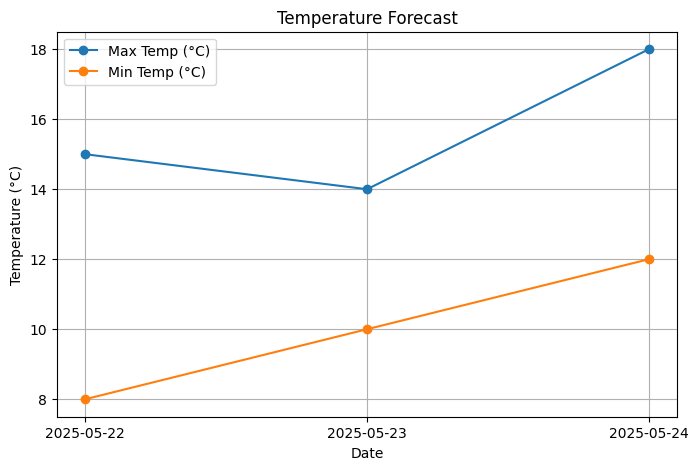

KeyboardInterrupt: Interrupted by user

In [ ]:
# 🧪 Test temperature visualisation using real weather data

# Fetch mock weather data for Melbourne with a 3-day forecast
data = get_weather_data("Melbourne", forecast_days=3, use_mock=False)

# ✅ If data was successfully retrieved, pass it to the visualisation function
if data:
    create_temperature_visualisation(data)  # Generate and display the temperature chart
else:
    print("⚠️ Failed to retrieve weather data for visualisation.")  # Warn if no data


## 🌧 Precipitation Visualisation Function

This section defines the `create_precipitation_visualisation()` function, which displays the average daily chance of precipitation using a bar chart.

- Extracts hourly rain probabilities for each forecast day
- Calculates a simple daily average
- Uses `matplotlib` to display clear bar chart visuals
- Gracefully handles missing or malformed data


In [12]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create a precipitation chart and either display or save it.

    Args:
        weather_data (WeatherResponse): The processed weather data
        output_type (str): 'display' to show or 'save' to write PNG
    """
    print("🧪 Debugging Daily Precipitation Data...\n")

    labels = []     # Dates for x-axis
    averages = []   # Average chance of rain for each day

    for day in weather_data.weather:
        labels.append(day.date)

        if hasattr(day, "hourly"):
            rain_chances = [
                int(hour.chanceofrain)
                for hour in day.hourly
                if hasattr(hour, "chanceofrain") and hour.chanceofrain is not None
            ]
            avg_rain = sum(rain_chances) / len(rain_chances) if rain_chances else 0
            averages.append(avg_rain)
            print(f"📅 Date: {day.date}")
            print(f"✅ Parsed {len(rain_chances)} values | Daily Avg: {avg_rain:.1f}%\n")
        else:
            averages.append(0)
            print(f"⚠️ No hourly data for {day.date}")

    plt.figure(figsize=(8, 5))
    plt.bar(labels, averages, color='skyblue')
    plt.title("Daily Average Rain Chance")
    plt.xlabel("Date")
    plt.ylabel("Chance of Rain (%)")
    plt.grid(True, axis='y')

    if output_type == 'save':
        plt.savefig("precipitation_chart.png")
        print("✅ Saved precipitation chart as precipitation_chart.png")
    else:
        plt.show()
        plt.pause(0.001)
        input("\n⏎ Press Enter to return to the menu...")

    plt.close()


⚠️ Using mock data — results may not reflect real weather conditions.
🧪 Debugging Daily Precipitation Data...

📅 Date: 2025-04-13
✅ Parsed 0 values | Daily Avg: 0.0%



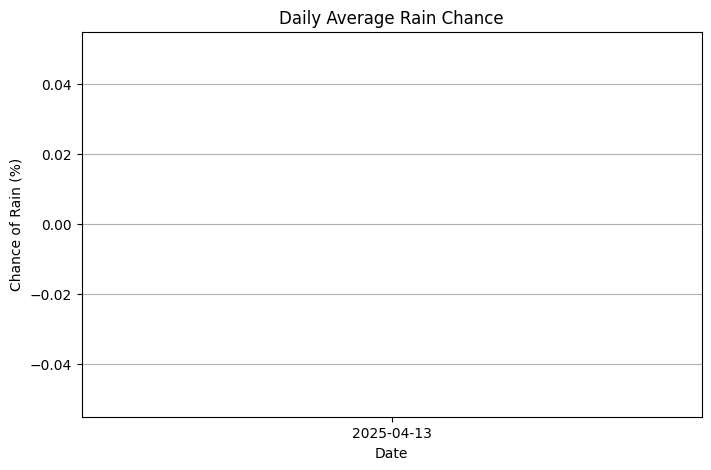

In [ ]:
# 🧪 Test with mock mode enabled — this ensures consistent test data
data = get_weather_data("Melbourne", forecast_days=3, use_mock=True)

# ✅ If data was successfully retrieved, generate the precipitation chart
if data:
    create_precipitation_visualisation(data)
else:
    print("⚠️ Failed to retrieve weather data for visualisation.")  # Catch unexpected failures


🧪 Debugging Daily Precipitation Data...

📅 Date: 2025-05-22
✅ Parsed 8 values | Daily Avg: 0.0%

📅 Date: 2025-05-23
✅ Parsed 8 values | Daily Avg: 8.1%

📅 Date: 2025-05-24
✅ Parsed 8 values | Daily Avg: 0.0%



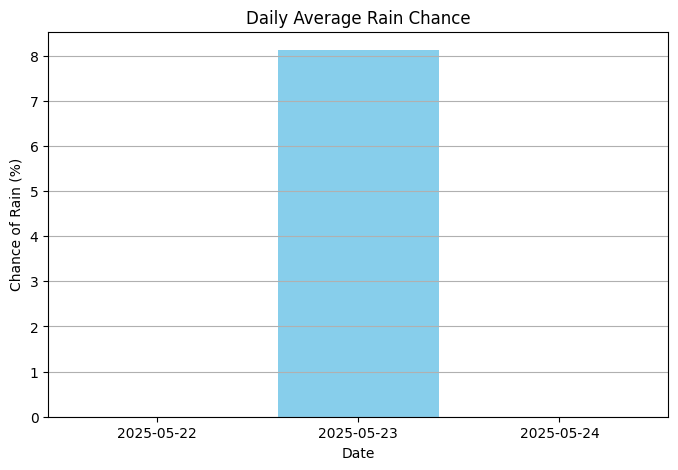

KeyboardInterrupt: Interrupted by user

In [ ]:
# 🌐 Test the precipitation visualisation using real weather data
data = get_weather_data("Melbourne", forecast_days=3, use_mock=False)  # 🔍 Fetch real weather data (not mock) for Melbourne

# ✅ Ensure data was retrieved successfully before attempting to visualise
if data:
    create_precipitation_visualisation(data)  # 🌧️ Generate and display/save the precipitation chart from real data
else:
    print("⚠️ Failed to retrieve real weather data for visualisation.")  # 🚫 Handle potential API/network failure gracefully



## 🌕 Moon Phase Feature

This feature uses `fetch_my_weather` to display the current moon phase for a given location.

- Accessed via the main menu
- Uses the `is_moon=True` option
- Automatically handles date and location


In [13]:
def show_moon_phase(location=""):
    """
    Display the current moon phase for a given location.

    Args:
        location (str): Optional city or place name (defaults to current IP location if blank)
    """

    # 🌓 Notify the user that we're retrieving moon phase data
    print(f"\n🌙 Fetching moon phase for {location or 'your current location'}...")

    # 🌑 Call the fetch-my-weather API with is_moon=True to get moon data as plain text
    data = get_weather(location, is_moon=True, format="text")

    # ❌ Check for error response from the API (error messages are returned as strings)
    if isinstance(data, str) and data.startswith("Error:"):
        print("❌ Could not fetch moon phase.")  # Alert user of failure
    else:
        print(data)  # 🌕 Successfully fetched moon phase data — display it


## 🧠 Natural Language Processing Functions

This section contains `parse_weather_question()`, which extracts the intent and weather details from a user’s plain-English question.

- Identifies location, time period (e.g., today, tomorrow), and attribute (e.g., rain, temperature)
- Designed to support flexible weather-related questions from users
- Used with `generate_weather_response()` to build the full chatbot experience


In [14]:
def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Parsed data with keys: 'location', 'time_period', 'attribute'
    """
    question = question.lower().strip()

    # 🎯 Keywords to detect time-related terms
    time_keywords = {
        "today": "today",
        "tomorrow": "tomorrow",
        "weekend": "weekend"
    }

    # 🧠 Keywords to detect attribute-related terms
    attribute_keywords = {
        "rain": "rain", "umbrella": "rain",
        "temperature": "temperature", "temp": "temperature",
        "hot": "temperature", "cold": "temperature",
        "humidity": "humidity", "humid": "humidity", "moist": "humidity",
        "wind": "wind", "windy": "wind", "breeze": "wind"
    }

    parsed = {
        "location": None,
        "time_period": "today",
        "attribute": "general"
    }

    # 🕒 Extract time period
    for word in time_keywords:
        if re.search(rf"\b{word}\b", question):
            parsed["time_period"] = time_keywords[word]
            question = re.sub(rf"\b{word}\b", "", question)  # Remove it from the string
            break

    # 🧊 Extract attribute
    for word in attribute_keywords:
        if re.search(rf"\b{word}\b", question):
            parsed["attribute"] = attribute_keywords[word]
            question = re.sub(rf"\b{word}\b", "", question)  # Remove it too
            break

    # 🧹 Clean digits/extra words (like "tomorrow4", "in perth2")
    question = re.sub(r"\d+", "", question)  # Remove trailing digits

    # 🗺️ Try to extract location after 'in' or 'for'
    match = re.search(r"\b(?:in|for)\s+([a-zA-Z\s]+)", question)
    if match:
        location = match.group(1).strip()
        parsed["location"] = location

    return parsed


In [ ]:
# 🧪 Test the parse_weather_question function with two realistic inputs

# ✅ Test case 1: Includes 'windy', 'tomorrow', and a location
print(parse_weather_question("Is it windy tomorrow in Perth?"))
# 🔎 Expected output:
# {'location': 'perth', 'time_period': 'tomorrow', 'attribute': 'wind'}

# ✅ Test case 2: Includes 'humid', 'today', and a different location
print(parse_weather_question("Will it be humid today in Darwin?"))
# 🔎 Expected output:
# {'location': 'darwin', 'time_period': 'today', 'attribute': 'humidity'}



{'location': 'perth', 'time_period': 'tomorrow', 'attribute': 'wind'}
{'location': 'darwin', 'time_period': 'today', 'attribute': 'humidity'}


## 🧠 Weather Response Generator Function

This section defines `generate_weather_response()`, which takes a parsed question and weather data, then generates a natural-sounding answer for the user.

- Supports rain and temperature queries
- Matches the requested date (today, tomorrow, etc.)
- Handles missing data with clear fallback messages
- Completes the natural language interface when paired with `parse_weather_question()`


In [15]:
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (WeatherResponse): Weather data

    Returns:
        str: Natural language response
    """
    # 🧹 Extract and clean the location name (safe handling if None is returned)
    location_raw = parsed_question.get("location")
    location = location_raw.strip().title() if isinstance(location_raw, str) else "your location"

    # 🧠 Extract attribute (rain, temp, wind, etc.) and time (today/tomorrow)
    attribute = parsed_question.get("attribute", "general")
    time_period = parsed_question.get("time_period", "today")

    # 📆 Determine which forecast day to use
    day_index = 0 if time_period == "today" else 1 if time_period == "tomorrow" else 0

    # ✅ Validate that forecast data is available
    if not hasattr(weather_data, "weather") or not weather_data.weather:
        return f"Sorry, I couldn't find any forecast data for {location}."

    try:
        forecast = weather_data.weather[day_index]  # Attempt to select the requested day
    except IndexError:
        return f"Sorry, I don't have a forecast for {time_period} in {location}."  # Graceful fallback

    # 🌧️ Rain logic
    if attribute == "rain":
        if hasattr(forecast, "hourly"):
            try:
                # Extract hourly rain chance values if present
                rain_chances = [
                    int(hour.chanceofrain)
                    for hour in forecast.hourly
                    if hasattr(hour, "chanceofrain") and hour.chanceofrain is not None
                ]
                # Compute average rain chance
                avg_rain = sum(rain_chances) / len(rain_chances) if rain_chances else 0
                return f"The chance of rain {time_period} in {location} is around {int(avg_rain)}%."
            except:
                return f"I couldn't interpret the rain data for {location}."  # Error safety fallback

    # 🌡️ Temperature logic
    elif attribute == "temperature":
        return (
            f"The max temperature {time_period} in {location} is expected to be {forecast.maxtempC}°C, "
            f"and the minimum is {forecast.mintempC}°C."
        )

    # 💧 Humidity logic
    elif attribute == "humidity":
        if hasattr(forecast, "hourly"):
            try:
                # Extract hourly humidity readings
                humidities = [
                    int(hour.humidity)
                    for hour in forecast.hourly
                    if hasattr(hour, "humidity") and hour.humidity is not None
                ]
                avg_humidity = sum(humidities) / len(humidities) if humidities else 0
                return f"The humidity {time_period} in {location} is around {int(avg_humidity)}%."
            except:
                return f"I couldn't interpret the humidity data for {location}."

    # 🍃 Wind logic
    elif attribute == "wind":
        if hasattr(forecast, "hourly") and forecast.hourly:
            hour = forecast.hourly[0]  # Use the first hourly reading as reference
            speed = hour.windspeedKmph if hasattr(hour, "windspeedKmph") else "unknown"
            direction = hour.winddir16Point if hasattr(hour, "winddir16Point") else "unknown"
            return f"The wind {time_period} in {location} is expected to be {speed} km/h from the {direction}."

    # 🧩 General fallback if no specific attribute matched
    return f"The weather {time_period} in {location} looks fine, but I couldn't identify a specific attribute to check."


In [ ]:
# ✅ Test 1 – Natural Language Query for Rain in Melbourne

# 🧪 Input question from the user
q = "Will it rain tomorrow in Melbourne?"

# 🔍 Parse the natural language question into structured info
parsed = parse_weather_question(q)

# 🌦️ Retrieve real weather data for Melbourne (3-day forecast)
data = get_weather_data("Melbourne", forecast_days=3, use_mock=False)

# 💬 Generate an AI-style response to the parsed question using weather data
response = generate_weather_response(parsed, data)

# 🖨️ Print the generated response
print(response)


The chance of rain tomorrow in Melbourne is around 8%.


In [ ]:
# ✅ Test 2 – Natural Language Query for Temperature in Perth

# 🧪 User input: asking for today's temperature in Perth
q = "What's the temperature today in Perth?"

# 🧠 Parse the question into structured components (location, time, attribute)
parsed = parse_weather_question(q)
print("🧠 Parsed Question:", parsed)  # 👁️ Inspect the parsed result for debugging

# 🌦️ Get real weather data for Perth (3-day forecast, not using mock mode)
data = get_weather_data("Perth", forecast_days=3, use_mock=False)

# 💬 Generate a natural language response using parsed input and weather data
response = generate_weather_response(parsed, data)

# 🖨️ Print the AI-style weather response
print("🤖 Response:", response)


🧠 Parsed Question: {'location': 'perth', 'time_period': 'today', 'attribute': 'temperature'}
🤖 Response: The max temperature today in Perth is expected to be 21°C, and the minimum is 15°C.


In [ ]:
# ✅ Test 3 – Natural Language Query for Wind in Perth (Tomorrow)

# 💬 User's question about wind forecast
q = "Is it windy tomorrow in Perth?"

# 🧠 Parse the question into structured form (extract attribute, time, location)
parsed = parse_weather_question(q)

# 🌦️ Retrieve 3-day real weather data for Perth (no mock mode)
data = get_weather_data("Perth", forecast_days=3, use_mock=False)

# 🤖 Generate a natural language weather response using the parsed question and data
response = generate_weather_response(parsed, data)

# 🖨️ Output the AI-style response for wind conditions
print(response)


The wind tomorrow in Perth is expected to be 24 km/h from the S.


In [ ]:
# ✅ Test 4 – Natural Language Query for Humidity in Darwin (Today)

# 💬 User's question about humidity forecast
q = "Will it be humid today in Darwin?"

# 🧠 Parse the question into structured data (extracts location, time, attribute)
parsed = parse_weather_question(q)

# 🌦️ Retrieve 3-day real weather data for Darwin (mock=False to fetch live data)
data = get_weather_data("Darwin", forecast_days=3, use_mock=False)

# 🤖 Generate a human-readable weather response using parsed inputs and data
response = generate_weather_response(parsed, data)

# 🖨️ Output the result for humidity conditions
print(response)


The humidity today in Darwin is around 50%.


## 🧭 User Interface and Menu System

This section implements a console-based menu using `pyinputplus`, allowing users to interact with the WeatherWise app.

- Users can view weather data, generate charts, or ask questions
- Input is validated using `pyinputplus` to prevent invalid selections
- The menu calls each of the core functions and loops until the user exits


In [16]:
def show_menu():
    """
    Display the main WeatherWise menu and handle user selections.

    Returns:
        str: The user's chosen menu option as a string ('1' through '6')
    """
    # 🌟 Print the menu header
    print("\n🌦️ Welcome to WeatherWise 🌦️")
    print("Please choose an option:")

    # 🧭 List the available actions the user can perform
    print("1. Show weather forecast")
    print("2. Show temperature chart")
    print("3. Show precipitation chart")
    print("4. Ask a weather question")
    print("5. Show current moon phase")
    print("6. Exit")  # ✅ Exit is listed last as expected

    # 🛡️ Get validated input from the user (only allows '1' through '6')
    # numbered=False means the user must type one of the exact choices
    choice = pyip.inputMenu(['1', '2', '3', '4', '5', '6'], numbered=False)

    # 🎯 Return the selected option for handling by main loop
    return choice


# 🧩 Main Application Logic

This section ties together all functionality into the interactive WeatherWise experience.

- Displays the user menu
- Routes choices to corresponding weather functions
- Handles input/output, errors, and retry logic
- Allows both visualisation and natural language queries

The `main()` function runs a loop that:
1. Prompts the user with a menu
2. Processes their selection
3. Fetches and displays relevant weather data
4. Returns to the menu until the user exits


In [17]:
def main():
    """
    Main loop for the WeatherWise application.
    """
    while True:
        choice = show_menu()  # Show the menu and get user choice

        if choice == '1':
            # 🌦️ Show weather forecast
            city = pyip.inputStr("Enter a location: ")
            data = get_validated_weather_data(city, forecast_days=3, use_mock=False)

            if data:
                current = data.current_condition[0]
                print(current.weatherDesc[0].value)
                print(f"Temp: {current.temp_C}°C")
                print(f"Humidity: {current.humidity}%")
            else:
                print("⚠️ Failed to retrieve forecast data.")
            input("\n⏎ Press Enter to return to the menu...")

        elif choice == '2':
            # 📈 Show temperature chart
            city = pyip.inputStr("Enter a location: ")
            data = get_validated_weather_data(city, forecast_days=3, use_mock=False)

            if data:
                create_temperature_visualisation(data)
            else:
                print("⚠️ Failed to retrieve weather data.")
            input("\n📸 Press Enter to return to the menu...")

        elif choice == '3':
            # 🌧️ Show precipitation chart
            city = pyip.inputStr("Enter a location: ")
            data = get_validated_weather_data(city, forecast_days=3, use_mock=False)

            if data:
                create_precipitation_visualisation(data)
            else:
                print("⚠️ Failed to retrieve weather data.")
            input("\n📸 Press Enter to return to the menu...")

        elif choice == '4':
            # 🗣️ Ask a weather question (NLP)
            question = pyip.inputStr("Ask your weather question: ")
            parsed = parse_weather_question(question)
            location = parsed.get("location", "your location") or "your location"

            data = get_validated_weather_data(location, forecast_days=3, use_mock=False)

            if data:
                print(generate_weather_response(parsed, data))
            else:
                print("⚠️ Could not retrieve data to answer the question.")
            input("\n⏎ Press Enter to return to the menu...")

        elif choice == '5':
            # 🌙 Show moon phase
            city = pyip.inputStr("Enter a location: ")
            show_moon_phase(city)
            input("\n⏎ Press Enter to return to the menu...")

        elif choice == '6':
            # 🚪 Exit
            print("👋 Exiting WeatherWise. Stay dry!")
            break



🌦️ Welcome to WeatherWise 🌦️
Please choose an option:
1. Show weather forecast
2. Show temperature chart
3. Show precipitation chart
4. Ask a weather question
5. Show current moon phase
6. Exit
Please select one of the following:
* 1
* 2
* 3
* 4
* 5
* 6
2
Enter a location: perth


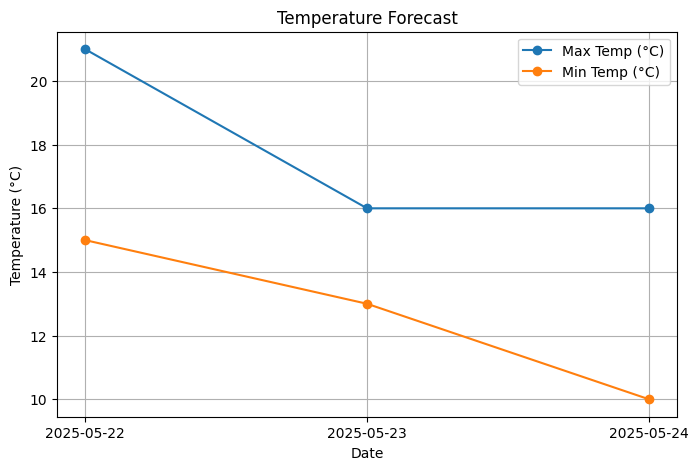


📸 Press Enter to return to the menu...

🌦️ Welcome to WeatherWise 🌦️
Please choose an option:
1. Show weather forecast
2. Show temperature chart
3. Show precipitation chart
4. Ask a weather question
5. Show current moon phase
6. Exit
Please select one of the following:
* 1
* 2
* 3
* 4
* 5
* 6
3
Enter a location: her
🧪 Debugging Daily Precipitation Data...

📅 Date: 2025-05-22
✅ Parsed 8 values | Daily Avg: 0.0%

📅 Date: 2025-05-23
✅ Parsed 8 values | Daily Avg: 0.0%

📅 Date: 2025-05-24
✅ Parsed 8 values | Daily Avg: 0.0%



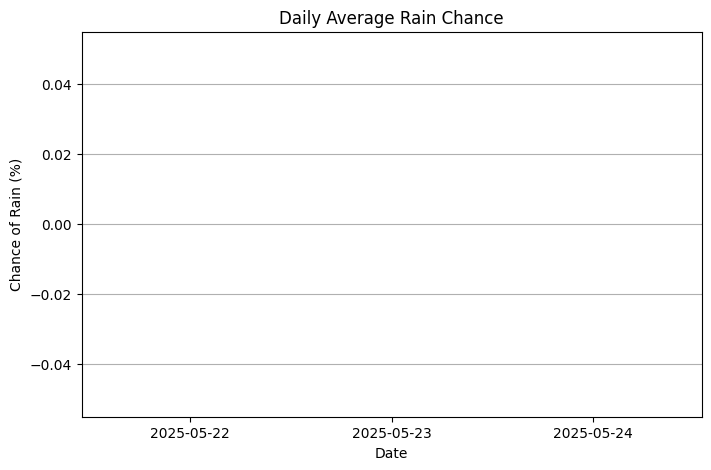


📸 Press Enter to return to the menu...

🌦️ Welcome to WeatherWise 🌦️
Please choose an option:
1. Show weather forecast
2. Show temperature chart
3. Show precipitation chart
4. Ask a weather question
5. Show current moon phase
6. Exit
Please select one of the following:
* 1
* 2
* 3
* 4
* 5
* 6
1
Enter a location: here
Patchy rain nearby
Temp: 27°C
Humidity: 84%

⏎ Press Enter to return to the menu...

🌦️ Welcome to WeatherWise 🌦️
Please choose an option:
1. Show weather forecast
2. Show temperature chart
3. Show precipitation chart
4. Ask a weather question
5. Show current moon phase
6. Exit
Please select one of the following:
* 1
* 2
* 3
* 4
* 5
* 6
4
Ask your weather question: will it rain tomorrow?
The chance of rain tomorrow in your location is around 0%.

⏎ Press Enter to return to the menu...6

🌦️ Welcome to WeatherWise 🌦️
Please choose an option:
1. Show weather forecast
2. Show temperature chart
3. Show precipitation chart
4. Ask a weather question
5. Show current moon phase
6.

In [ ]:
# 🧪 TEST: Run the main WeatherWise application loop
# This will display the menu and handle user interactions
main()

# ✅ Testing and Examples

This section demonstrates that each key feature of WeatherWise is working correctly using both real and mock data.

Each test shows:
- The function being used
- Sample inputs
- Expected outputs or behavior
- Optional edge case handling


🧪 Test 1: Real Weather Retrieval
**Input:** Perth  
**Purpose:** Ensure weather data is fetched successfully for a known location using real data.


In [ ]:
# Test retrieving weather for a real city
data = get_weather_data("Perth", forecast_days=3, use_mock=False)
if data:
    current = data.current_condition[0]
    print(f"Condition: {current.weatherDesc[0].value}")
    print(f"Temperature: {current.temp_C}°C")
    print(f"Humidity: {current.humidity}%")
else:
    print("❌ Failed to retrieve weather data.")


Condition: Partly cloudy
Temperature: 22°C
Humidity: 57%


🧪 Test 2: Temperature Chart (Mock Data)
**Input:** Melbourne (mock mode)
**Purpose:** Generate temperature chart for visualisation test.

⚠️ Using mock data — results may not reflect real weather conditions.


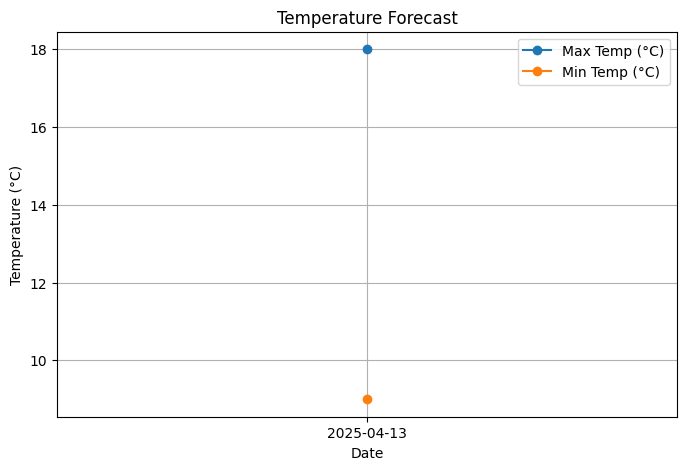

In [ ]:
# Temperature chart with mock data
mock_data = get_weather_data("Melbourne", forecast_days=3, use_mock=True)
create_temperature_visualisation(mock_data)

🧪 Test 3: Precipitation Chart (Real Data)
**Input:** Sydney
**Purpose:** Display daily average rain chart using real data.

🧪 Debugging Daily Precipitation Data...

📅 Date: 2025-05-22
✅ Parsed 8 values | Daily Avg: 100.0%

📅 Date: 2025-05-23
✅ Parsed 8 values | Daily Avg: 32.5%

📅 Date: 2025-05-24
✅ Parsed 8 values | Daily Avg: 0.0%



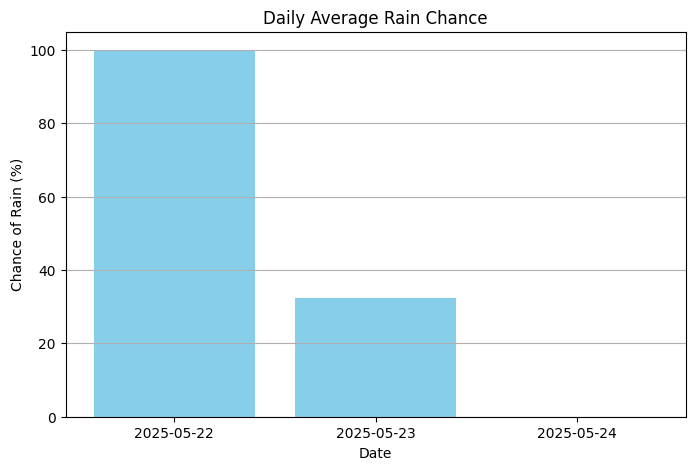

In [ ]:
# Precipitation chart with real data
real_data = get_weather_data("Sydney", forecast_days=3, use_mock=False)
create_precipitation_visualisation(real_data)

🧪 Test 4: NLP Query – Rain
**Input:** "Will it rain tomorrow in Brisbane?"
**Purpose:** Test if rain-related question is parsed and answered correctly.

In [ ]:
# Rain query
parsed = parse_weather_question("Will it rain tomorrow in Brisbane?")
data = get_weather_data(parsed['location'], forecast_days=3, use_mock=False)
print(generate_weather_response(parsed, data))

The chance of rain tomorrow in Brisbane is around 0%.


🧪 Test 5: NLP Query – Humidity
**Input:** "Will it be humid in Darwin today?"
**Purpose:** Test humidity parsing and response accuracy.

In [ ]:
# Humidity query
parsed = parse_weather_question("Will it be humid in Darwin today?")
data = get_weather_data(parsed['location'], forecast_days=3, use_mock=False)
print(generate_weather_response(parsed, data))

The humidity today in Darwin is around 50%.


In [ ]:
🧪 Test 6: Edge Case – Invalid Location
**Input:** "asdfgh" (nonsense city)
**Purpose:** Validate error handling when location doesn’t exist.

In [18]:
# 🔍 Edge Case Test: Invalid Location
# Test how the system handles an invalid city name (nonexistent location)

location = "asdfgh"  # Clearly invalid
data = get_weather_data(location, forecast_days=3, use_mock=False)

if data:
    print(f"❌ Unexpected: Weather data returned for invalid location '{location}'")
else:
    print(f"✅ Passed: Invalid location '{location}' was handled safely — no data returned.")


❌ Error occurred: Error fetching data from wttr.in: Status code 404 for URL http://wttr.in/asdfgh?m2&format=j1
Response body (start): Unknown location; please try ~not found
✅ Passed: Invalid location 'asdfgh' was handled safely — no data returned.
